# IN PROGRESS!!!!! dzisiaj skończe :)

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay
)

# Classification of a Heart with Hypertrophic Cardiomyopathy (Cardiomegaly)

### Specify data file path

In [6]:
csv_path = "task_data.csv"

## Load data

Make sure to specify correct decimal separator

In [15]:
df = pd.read_csv(csv_path, decimal=',')

print("Loaded:", df.shape)
print("Columns:", list(df.columns)[:14])

id_col = df.columns[0]
label_col = df.columns[1]

X = df.drop(columns=[id_col, label_col])
y = df[label_col]


Loaded: (37, 14)
Columns: ['ID', 'Cardiomegaly', 'Heart width', 'Lung width', 'CTR - Cardiothoracic Ratio', 'xx', 'yy', 'xy', 'normalized_diff', 'Inscribed circle radius', 'Polygon Area Ratio', 'Heart perimeter', 'Heart area ', 'Lung area']


## Split the data into trainting and test sets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("\nTrain/test shapes:", X_train.shape, X_test.shape)

print("Train label distribution:\n", y_train.value_counts())
print("Test  label distribution:\n", y_test.value_counts())


Train/test shapes: (29, 12) (8, 12)
Train label distribution:
 Cardiomegaly
1    22
0     7
Name: count, dtype: int64
Test  label distribution:
 Cardiomegaly
1    6
0    2
Name: count, dtype: int64


## KNN model

As you can see accuract isn't the best. Also data set is very small, only 29 samples in train set. Also it is imbalanced as only 7 samples represents healthy hearts.

In [31]:
pipe_knn = Pipeline(steps=[
    ("scaler", StandardScaler()),     
    ("model", KNeighborsClassifier( 
        n_neighbors=3,             
        weights='distance',        
        metric='manhattan'
    ))
])

pipe_knn.fit(X_train, y_train)

cv_scores = cross_val_score(pipe_knn, X_train, y_train, cv=5)

print("Accuracy per fold:", np.round(cv_scores, 3))
print(f"Mean CV accuracy: {cv_scores.mean():.3f}")
print(f"Standard deviation: {cv_scores.std():.3f}")

Accuracy per fold: [0.833 0.833 0.833 0.667 0.6  ]
Mean CV accuracy: 0.753
Standard deviation: 0.100


First lets improve validation method. This method is better for small datasets as it repeats the KFold validation multiple times. As you can see we estimated a bit higher accuracy this time.

In [37]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

scores = cross_val_score(pipe_knn, X_train, y_train, cv=cv)

print(f"Mean CV accuracy: {scores.mean():.3f}")
print(f"Standard deviation: {scores.std():.3f}")

Mean CV accuracy: 0.773
Standard deviation: 0.144


Now lets try to optimize model hyperparameters for better accuracy.

In [42]:
param_grid = {
    'model__n_neighbors': [1, 3, 5, 7, 9, 11, 15],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

pipe_knn = Pipeline(steps=[
    ("scaler", StandardScaler()),           
    ("model", KNeighborsClassifier())     
])

grid = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1 
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print(f"Best cross-val accuracy: {grid.best_score_:.3f}")

Best parameters: {'model__metric': 'euclidean', 'model__n_neighbors': 1, 'model__weights': 'uniform'}
Best cross-val accuracy: 0.831


I found that the best parameters for KNN are: `{'model__metric': 'euclidean', 'model__n_neighbors': 1, 'model__weights': 'uniform'}`

We achieved a significantly better accuracy — an improvement of about 6%.

Lets save this model for later evaluation.

In [43]:
best_knn = grid.best_estimator_

## Logistic regression

Similarly to KNN I will use grid search to find best hyperparameters to optimize accurracy.

In [ ]:
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])

param_grid = {
    "model__C": np.logspace(-3, 3, 10),
    "model__penalty": ["l1", "l2"],
    "model__solver": ["liblinear", "saga"],
}

cv = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=10,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.3f}")

best_lr = grid_search.best_estimator_

Best parameters: {'model__C': np.float64(46.41588833612773), 'model__penalty': 'l2', 'model__solver': 'saga'}
Best cross-validation accuracy: 0.767


c:\Dev\AI_MED_Recruitment\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


I will allow more iterations as warning says that current result might be not optimal.

In [46]:
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=5000))
])

param_grid = {
    "model__C": np.logspace(-3, 3, 10),
    "model__penalty": ["l1", "l2"],
    "model__solver": ["liblinear", "saga"],
}

cv = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=10,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.3f}")

best_lr = grid_search.best_estimator_

Best parameters: {'model__C': np.float64(215.44346900318823), 'model__penalty': 'l2', 'model__solver': 'saga'}
Best cross-validation accuracy: 0.768


We got almost 77% accuracy which is worse than KNN but lets keep it for final test.

## SVM

In [48]:
pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC())
])

param_grid = {
    "model__C": np.logspace(-3, 3, 10),
    "model__kernel": ["linear", "rbf", "poly"],
    "model__gamma": ["scale", "auto"]
}

cv = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=10,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=pipe_svm,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.3f}")

best_svc = grid_search.best_estimator_

Best parameters: {'model__C': np.float64(10.0), 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best cross-validation accuracy: 0.841


We got pretty good accuracy using this model.

## Random forest

I will use random search this time for faster runtime.

In [54]:
pipe_rf = Pipeline([
    ("model", RandomForestClassifier(random_state=42))
])

param_grid = {
    "model__n_estimators": [50, 100, 200],      # number of trees
    "model__max_depth": [None, 5, 10, 20],      # tree depth (None = unlimited)
    "model__min_samples_split": [2, 5, 10],     # min samples to split a node
    "model__min_samples_leaf": [1, 2, 4],       # min samples at each leaf
    "model__max_features": ["sqrt", "log2"],    # number of features considered for split
    "model__bootstrap": [True, False]           # whether to use bootstrap samples
}

cv = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=3,
    random_state=42
)

search = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_grid,
    n_iter=100,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

print("Best parameters:", search.best_params_)
print(f"Best cross-validation accuracy: {search.best_score_:.3f}")

best_rf = search.best_estimator_

Best parameters: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 10, 'model__bootstrap': False}
Best cross-validation accuracy: 0.747


## Scores for trained models

| Classifier | Accuracy |
|------------|----------|
| KNN | 83% |
| Logistic Regression | 77% |
| SVM | 84% |
| Random Forest | 75% |

## Evaluating models on test dataset

In [56]:
models = [
    ('KNN', best_knn),
    ('Logistic Regression', best_lr),
    ('SVM', best_svc),
    ('Random Forest', best_rf)
    ]


=== KNN ===
Accuracy:  0.750
Precision: 0.833
Recall:    0.833
F1-score:  0.833


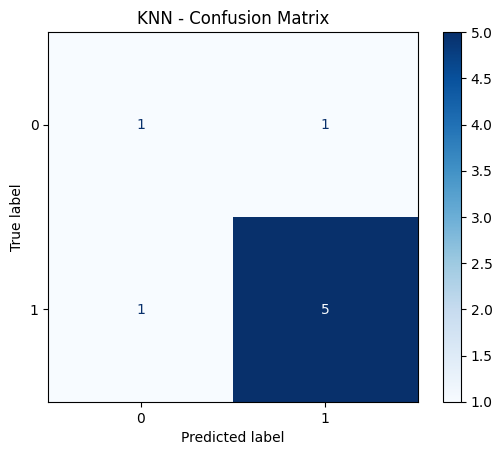

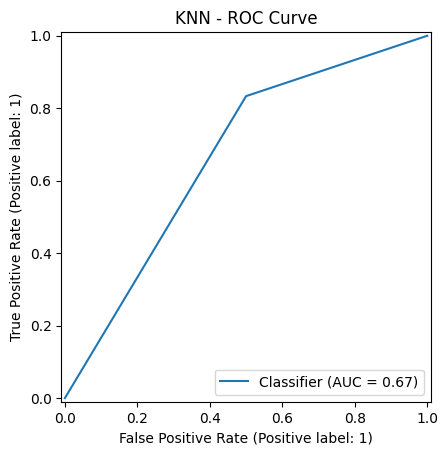

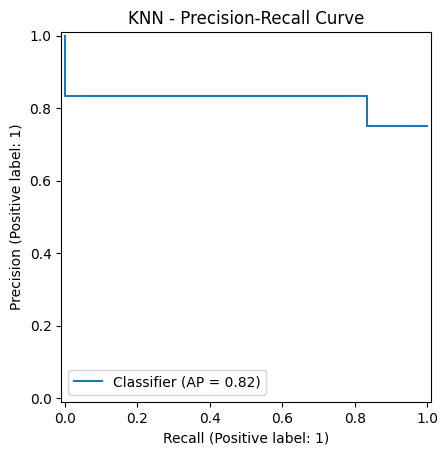


=== Logistic Regression ===
Accuracy:  0.625
Precision: 1.000
Recall:    0.500
F1-score:  0.667


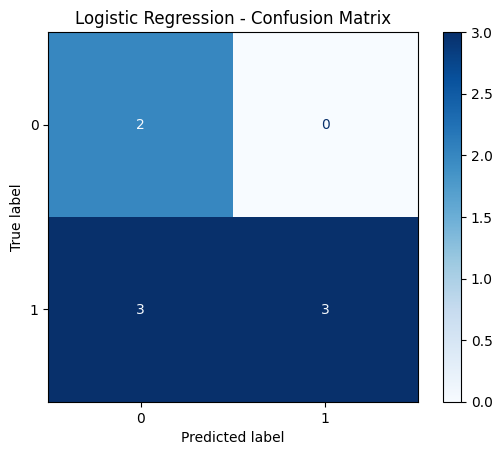

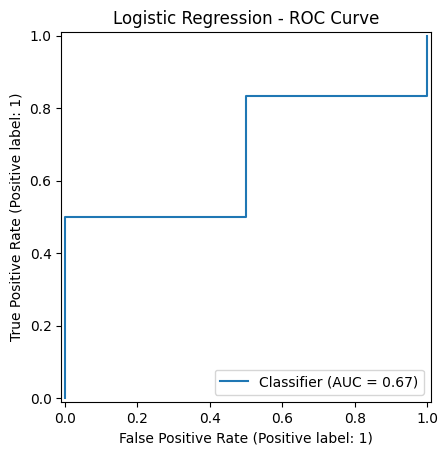

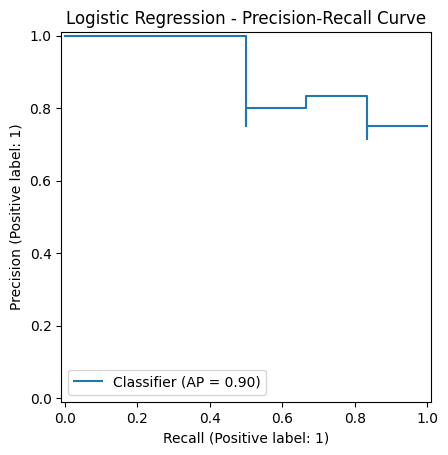


=== SVM ===
Accuracy:  0.750
Precision: 0.833
Recall:    0.833
F1-score:  0.833


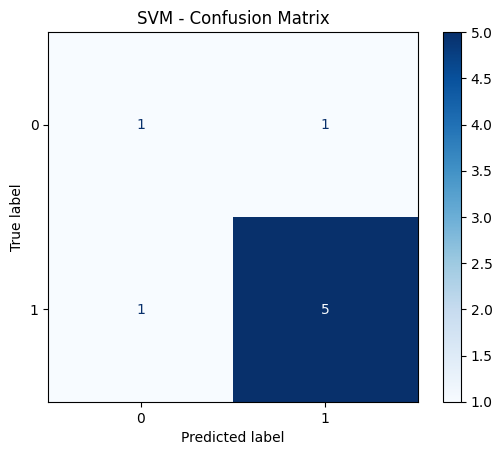

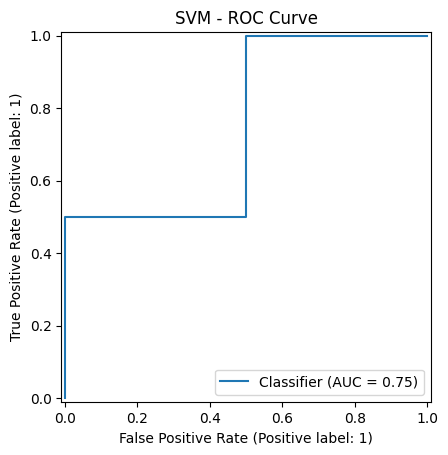

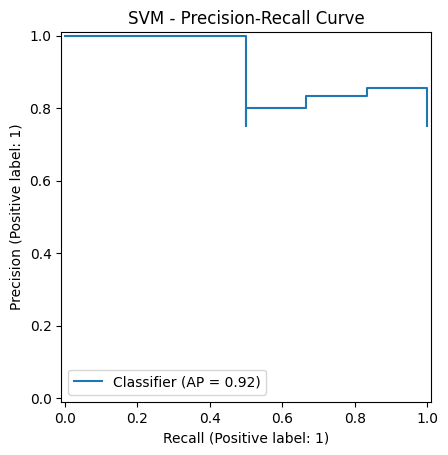


=== Random Forest ===
Accuracy:  0.750
Precision: 1.000
Recall:    0.667
F1-score:  0.800


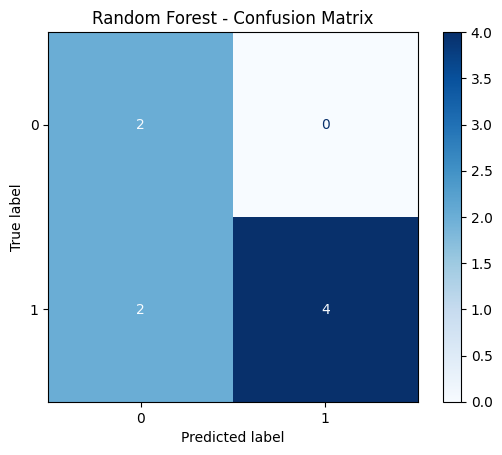

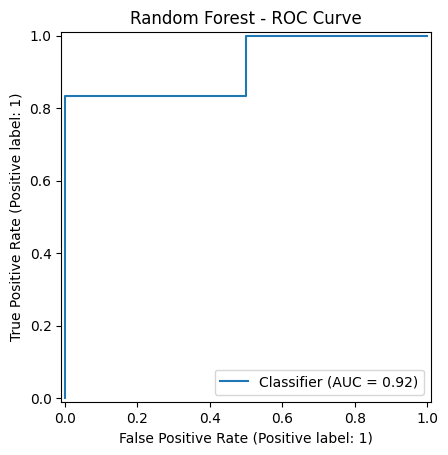

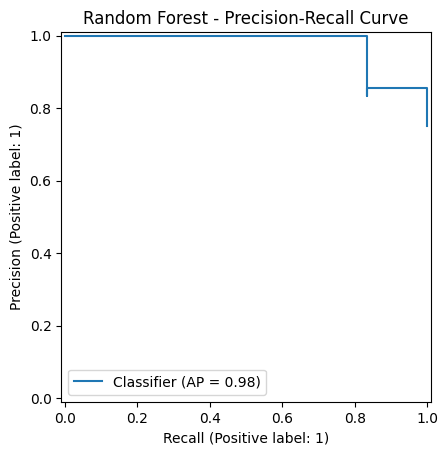

In [ ]:
for name, model in models:
    print(f"\n=== {name} ===")
    
    y_pred = model.predict(X_test)
    
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"F1-score: {f1:.3f}")
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()
    
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"{name} - ROC Curve")
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_test, y_proba)
    plt.title(f"{name} - Precision-Recall Curve")
    plt.show()